## Feature Extraction with Transformers Embedding

Project Goal: This notebook focuses on feature extraction using a pre-trained Transformer model. We convert raw tweet text into high-dimensional dense vectors (embeddings) to be used for downstream classification tasks.

In [1]:
import zipfile

zip_path = "data/nlp-getting-started.zip"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("data")

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

In [3]:
import torch
import numpy as np
import random
import os

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [4]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
df.isna().sum(), df.shape

(id             0
 keyword       61
 location    2533
 text           0
 target         0
 dtype: int64,
 (7613, 5))

In [7]:
df_test.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

<Axes: xlabel='target'>

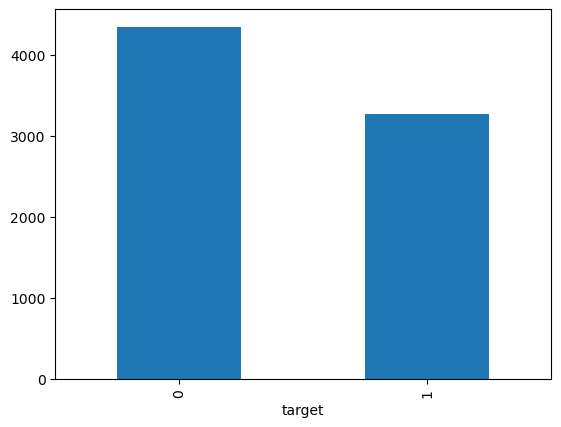

In [8]:
df['target'].value_counts().plot(kind="bar")

Data Exploration: Checking for missing values and class distribution. The dataset contains [7,613] training samples. The target distribution is relatively balanced, but we need to handle text cleaning and tokenization.

In [9]:
from datasets import Dataset, DatasetDict

raw_datasets = Dataset.from_pandas(df)
raw_test_datasets = Dataset.from_pandas(df_test)

dataset = DatasetDict({
    "train": raw_datasets,
    "test": raw_test_datasets
})

Model Selection: DeBERTa-v3-base I am using `microsoft/deberta-v3-base` for embedding generation. DeBERTa improves upon BERT/RoBERTa with disentangled attention and enhanced mask decoder, making it highly effective for capturing semantic meaning in short texts like tweets.

In [10]:
from transformers import AutoTokenizer, AutoModel
checkpoint = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(checkpoint, use_fast=False)
model = AutoModel.from_pretrained(checkpoint)

In [11]:
import torch

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
model.to(device)

DebertaV2Model(
  (embeddings): DebertaV2Embeddings(
    (word_embeddings): Embedding(128100, 768, padding_idx=0)
    (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): DebertaV2Encoder(
    (layer): ModuleList(
      (0-11): 12 x DebertaV2Layer(
        (attention): DebertaV2Attention(
          (self): DisentangledSelfAttention(
            (query_proj): Linear(in_features=768, out_features=768, bias=True)
            (key_proj): Linear(in_features=768, out_features=768, bias=True)
            (value_proj): Linear(in_features=768, out_features=768, bias=True)
            (pos_dropout): Dropout(p=0.1, inplace=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): DebertaV2SelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
            (dropout): Dropout(p=0.1, 

In [12]:
inputs_train = tokenizer(list(dataset["train"]["text"]), return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device)
inputs_test = tokenizer(list(dataset["test"]["text"]), return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device)

In [13]:
inputs_train

{'input_ids': tensor([[    1,   581, 65453,  ...,     0,     0,     0],
        [    1,  5089,  1351,  ...,     0,     0,     0],
        [    1,   545,  2138,  ...,     0,     0,     0],
        ...,
        [    1,   749,   435,  ...,     0,     0,     0],
        [    1,  2318,  7310,  ...,     0,     0,     0],
        [    1,   279, 10769,  ...,     0,     0,     0]], device='mps:0'), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='mps:0')}

Feature Extraction Strategy: We extract the last_hidden_state of the [CLS] token (index 0) from the model's output. This 768-dimensional vector serves as a compressed numerical representation of the entire tweet's context.

In [14]:
import numpy as np
from tqdm.auto import tqdm

def get_embeddings_safely(inputs, model, batch_size=16):
    n_samples = inputs["input_ids"].shape[0]
    all_embs = []
    
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, n_samples, batch_size)):
            batch_inputs = {
                k: v[i : i + batch_size].to(device) 
                for k, v in inputs.items()
            }
            
            outputs = model(**batch_inputs)
            
            emb = outputs.last_hidden_state[:, 0, :].detach().cpu().numpy()
            all_embs.append(emb)
            
    return np.vstack(all_embs)

X_train_emb = get_embeddings_safely(inputs_train, model)
X_test_emb = get_embeddings_safely(inputs_test, model)

  0%|          | 0/476 [00:00<?, ?it/s]

  0%|          | 0/204 [00:00<?, ?it/s]

In [15]:
type(X_train_emb), X_train_emb.shape

(numpy.ndarray, (7613, 768))

In [16]:
#save embedding data
np.save("data/train_embeddings.npy", X_train_emb)
np.save("data/test_embeddings.npy", X_test_emb)

In [17]:
train_df = pd.DataFrame(X_train_emb, columns=[f"emb_{i}" for i in range(X_train_emb.shape[1])])
test_df = pd.DataFrame(X_test_emb, columns=[f"emb_{i}" for i in range(X_test_emb.shape[1])])
train_df.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,0.105416,0.229255,0.032642,-0.067727,0.051010,-0.122849,0.020267,0.140387,-0.203620,0.032540,...,-0.104533,0.107250,-0.001299,0.064792,-0.013607,-0.052724,0.063353,-0.013496,0.193849,0.025834
1,0.097687,0.219986,0.058977,-0.084044,0.090142,-0.125159,-0.003105,0.114609,-0.197948,0.052772,...,-0.099950,0.081551,-0.049584,0.070057,-0.029232,-0.139531,0.015191,-0.054459,0.172969,-0.007371
2,0.139302,0.209250,0.051078,-0.071902,0.072903,-0.123652,0.011826,0.100010,-0.191934,0.066873,...,-0.121393,0.039200,-0.031125,0.041774,-0.000281,-0.116240,0.009761,-0.066319,0.165006,0.043972
3,0.147291,0.221638,0.029100,-0.075694,0.081218,-0.127636,0.022426,0.129949,-0.196388,0.061044,...,-0.101378,0.072086,-0.029069,0.031978,-0.007993,-0.131807,0.033268,-0.089738,0.172987,0.021650
4,0.142027,0.199940,0.022030,-0.064067,0.074370,-0.122768,0.008187,0.125156,-0.209924,0.063767,...,-0.101361,0.071649,-0.034237,0.011667,0.004223,-0.111813,0.009486,-0.042143,0.157490,0.027697


In [18]:
test_df.head()

,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,emb_9,...,emb_758,emb_759,emb_760,emb_761,emb_762,emb_763,emb_764,emb_765,emb_766,emb_767
0,0.093556,0.280927,-0.002096,-0.097005,0.055952,-0.143975,0.067673,0.146128,-0.274457,0.026737,...,-0.109216,0.113393,-0.011580,0.054889,0.020418,-0.160822,0.059513,-0.019760,0.121943,0.067450
1,0.079621,0.205653,0.030754,-0.051704,0.059690,-0.169810,0.015899,0.127003,-0.194120,0.054866,...,-0.146558,0.055638,-0.030462,0.081526,-0.024880,-0.146210,0.041236,-0.054024,0.174115,0.018981
2,0.158501,0.218529,-0.018100,-0.070581,0.049060,-0.133731,0.017909,0.141584,-0.232230,0.068538,...,-0.138229,0.058369,-0.056148,0.025727,0.018467,-0.146186,0.020222,-0.048834,0.162705,0.044592
3,0.140664,0.275799,0.028268,-0.120209,0.099596,-0.117537,0.058648,0.134527,-0.247418,0.029123,...,-0.094071,0.128857,0.027063,0.045559,0.013874,-0.097613,0.005977,-0.071455,0.185118,-0.053356
4,0.100574,0.249566,0.033952,-0.082817,0.080836,-0.116425,0.022706,0.136006,-0.253181,0.056174,...,-0.111931,0.084898,-0.019420,0.051788,0.010539,-0.100510,0.023766,-0.061118,0.159233,0.010078
